# Lesson 03: From Clustering To Classification

## k-nearest neighbor clustering
Recap the kmeans clustering result:

![by Weston.pace, from commons.wikimedia.org under CC-BY-SA 3.0](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/K_Means_Example_Step_4.svg/278px-K_Means_Example_Step_4.svg.png)

- in this case, we have $k=3$ clusters and hence have produced a dataset of form  
$ \mathcal{D}_{k=3} = \{ \langle \vec{x}_{1}, f(\vec{x}_{1}) \rangle, \dots \} $ 
  + where $f$ denotes a class label of a cluster, e.g. if $\vec{x}_{1}$ belongs to cluster $2$, then $f(\vec{x}_{1}) = 2$
  + in other words $f(\vec{x}_{1})$ represents the mathematical mapping that our `kmeans` applies to our dataset
  

## going for classification

- to use this for classification, we want to start from a fully labelled dataset
- given an unseen query point $\vec{x}_{q}$, we would like to know what cluster it belongs to

![by Sebastian Raschka, Stat 451: intro to ML](https://raw.githubusercontent.com/deeplearning540/lesson03/main/images/raschka_knn_p28.png)


- there are multiple options how to decide to which class the query point belongs to

![by Sebastian Raschka, Stat 451: intro to ML](https://raw.githubusercontent.com/deeplearning540/lesson03/main/images/raschka_knn_p29.png)

- **note** that the choice of $k$ determines the radius in this image above, here $k=5$ was set


- the plurality vote is mathematically known as the **mode** of a distribution of discrete numbers, i.e. the category with highest frequency wins

![by Sebastian Raschka, Stat 451: intro to ML](https://raw.githubusercontent.com/deeplearning540/lesson03/main/images/raschka_knn_p30.png)

- important: what hyper parameters govern the decision boundary?
  + the choice of distance metric, e.g. euclidean distance
  + the number of neighbors to consider, i.e. $k$
  

# Using kNN classification


## Data

For the following, I will rely (again) on the Palmer penguin dataset obtained from [this repo](https://github.com/allisonhorst/palmerpenguins). To quote the repo:

> Data were collected and made available by [Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php)
> and the [Palmer Station, Antarctica LTER](https://pal.lternet.edu/), a member of the [Long Term Ecological Research Network](https://lternet.edu/).


In [2]:
import pandas as pd
print("pandas version:", pd.__version__)


pandas version: 1.0.5


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv")
#let's remove the rows with NaN values
df = df[ df.bill_length_mm.notnull() ]

#convert species column to 
df[["species_"]] = df[["species"]].astype("category")

print(df.head())


  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  year species_  
0       3750.0    male  2007   Adelie  
1       3800.0  female  2007   Adelie  
2       3250.0  female  2007   Adelie  
4       3450.0  female  2007   Adelie  
5       3650.0    male  2007   Adelie  


In [4]:
print("species_ encoding:")
print("\n".join([ str(item)+" : "+df.species_.cat.categories[item] for item in range(len(df.species_.cat.categories)) ]))

species_ encoding:
0 : Adelie
1 : Chinstrap
2 : Gentoo


In [5]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
print(f'seaborn version: {sns.__version__}')

seaborn version: 0.10.1


In [6]:
from sklearn.neighbors import KNeighborsClassifier as knn
import numpy as np
kmeans = knn(n_neighbors=3)


In [7]:
#this time we train the knn algorithm, i.e. an unsupervised method is used in a supervised fashion
#prepare the data
X = np.stack((df.bill_length_mm, df.flipper_length_mm), axis=-1)
y = df.species_.cat.codes

print(X.shape)
print(y.shape)


(342, 2)
(342,)


In [8]:
#to create a fair comparison, we hold out a certain amount of the dataset
#so that we can test the algorithm on unseen samples
from sklearn.model_selection import train_test_split

#check class balances first
print(y.value_counts())



0    151
2    123
1     68
dtype: int64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .1,
                                                    random_state = 20210301)

print(X_train.shape)
print(y_train.shape)


print(X_test.shape)
print(y_test.shape)



(307, 2)
(307,)
(35, 2)
(35,)


In [10]:
#train_test_split shuffles the data
#this is a precaution to not prevent the algorithm from learning a sequence
#(the latter doesn't apply in this case)

for i in range(10):
    print(X[i], X_train[i])
    

[ 39.1 181. ] [ 40.3 195. ]
[ 39.5 186. ] [ 42. 200.]
[ 40.3 195. ] [ 49.4 216. ]
[ 36.7 193. ] [ 42.7 196. ]
[ 39.3 190. ] [ 47.5 199. ]
[ 38.9 181. ] [ 41.3 194. ]
[ 39.2 195. ] [ 37.3 192. ]
[ 34.1 193. ] [ 37.8 180. ]
[ 42. 190.] [ 46.2 217. ]
[ 37.8 186. ] [ 46.2 187. ]


In [11]:
kmeans = kmeans.fit(X_train, y_train)


In [12]:
#let's test our prediction for a single unseen item
x0_test = X_test[0].reshape(1,2)
print(x0_test, x0_test.shape)

y0_test_hat = kmeans.predict(x0_test)

print(f"predicted label {y0_test_hat}, true label {y_test.values[0]}")


[[ 45.1 215. ]] (1, 2)
predicted label [2], true label 2


In [13]:
#does this hold for the entire test set?
y_test_hat = kmeans.predict(X_test)
n_correct = (y_test_hat == y_test.values).sum()
print(f"{n_correct} out of {y_test.size} were correctly predicted")

32 out of 35 were correctly predicted


# Evaluating Classifications

Let's make our lives a bit easier and only look at a binary classification problem.

In [14]:
#to make our lives a bit easier, let's focus on a binary classification problem
#for this, let's focus on classifying label 0 only, labels 1 & 2 are summarize as 1

#effectively, we are only checking if a datum is assigned to the Adele species or not
binary_y_test_hat = (y_test_hat > 0).astype(np.int8)
binary_y_test = (y_test.values > 0).astype(np.int8)

print(binary_y_test_hat)
print(binary_y_test)

[1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1]
[1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1]


## Confusion Matrix
As we use the dataset in a supervised fashion, we know the ground truth by `binary_y_test`. This is our true condition.

From the predictions of our kNN classifier `binary_y_test_hat`, we obtain the predicted condition.

From these 2 quantities we can form, the confusion matrix:

![from wikipedia:Confusion_matrix](https://github.com/deeplearning540/lesson03/blob/main/images/screenshot_2021-02-23-confusion-matrix-wikipedia.png)


In our example with Penguins, the individual contributions come together as:

- **true positives** (TP): the datum is **predicted as an Adele** penguin and really is one (correct)
- **false negatives** (FN): the datum is **predicted as not an Adele** penguin and really is one 
- **false positives** (FP): the datum is **predicted as an Adele** penguin and but is Chinstrap or Gentoo
- **true negatives** (TN): the datum is **predicted as not an Adele** penguin and but is Chinstrap or Gentoo


In [15]:
#sklearn can help us with this too
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(binary_y_test, binary_y_test_hat)

print(cm)

#the sum of all entries must match the size of our test dataset
assert cm.sum() == binary_y_test.size


[[14  0]
 [ 3 18]]


In [16]:
tp = cm[0,0]
fp = cm[0,1]
fn = cm[1,0]
tn = cm[1,1]

assert tp == 14
assert fp == 0
assert fn == 3
assert tn == 18

assert ((tp, fp, fn, tn) == cm.ravel()).all(), f"{tp, fp, fn, tn} != {cm.ravel()}"


![inspired by Sebastian Raschka, Stat 451: intro to ML](https://github.com/deeplearning540/lesson03/blob/main/images/viz-confusion-matrix.png)



1


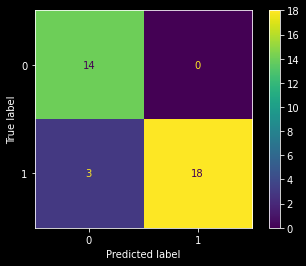

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(int(True))

from this confusion matrix, many evaluation metrics are construction. In the following, I will concentrate on the most commonly encountered.

## Accuracy

in layman's terms: how often was the prediction correct compared to the total number of guesses?

In [18]:
total = float(cm.sum())
accuracy = (tp + tn) / total

print(f"our kNN algorithm produced a test accuracy of {accuracy}")


our kNN algorithm produced a test accuracy of 0.9142857142857143


## Recall (also known as true positive rate)

in layman's terms: how many of the true class samples, do I get right?

In [19]:
cond_true = tp + fn
recall = tp / ( cond_true )

print(f"our kNN algorithm produced a test recall of {recall}")
assert cond_true == cm[:,0].sum()

our kNN algorithm produced a test recall of 0.8235294117647058


## Precision

in layman's terms: from all that I predict as positive, how many are correct?

In [20]:
pred_pos = tp + fp
precision = tp / pred_pos

print(f"our kNN algorithm produced a test precision of {precision}")

our kNN algorithm produced a test precision of 1.0


## F1 score
This is a combination of the recall and precision. 
$F_{1} = 2 \ctimes \frac{PRE \ctimes REC}{PRE + REC}$


In [21]:
f1 = 2*precision*recall/(precision+recall)

print(f"our kNN algorithm produced a test f1 of {f1}")

our kNN algorithm produced a test f1 of 0.9032258064516129


## Summary

- all evaluation metrics mentioned are within $[0,1]$
- they all express different aspects of what can go right/wrong with classification 
- their use is specific to the domain that you are working in
    + in biology or medicine, false positives or negatives can have large impact 
    + other disciplines value more, **what** was predicted and if it was correct
    + important: use a common language!
- similar approaches as above hold for multi-label classification

# Take-Aways

- nearest neighbor clustering algorithms can be used for classification 
- to quantify the performance of a classifyer, the data has to be split into a training and a test set (or more)
- for binary classification, the central resource to calculate evaluation metrics is the confusion matrix
- evaluation metrics express different aspects of what can go wrong with classification 


# Further Reading

- some parts of this material were inspired by [Sebastian Raschka](https://sebastianraschka.com)
  + confusion matrix [lesson 12.1](https://www.youtube.com/watch?v=07dtryhNGms)
  + precision, recall and F1 score [lesson 12.2](https://youtu.be/yEw9oDdJkT0)
  
- a generally good resource 
  + [Confusion_matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
  + [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)
  
- all of the above is nicely implemented and document
  + [evaluation metrics of classifyers](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)
  + []()